### Testing the backtester

{'mean': np.float64(-0.0006171942975426743), 'vol': 0.009288038123178726, 'sharpe': np.float64(-1.0548681649981837), 'max_drawdown': -0.29146133164823806, 'win_rate': np.float64(0.10570824524312897)}


<Axes: title={'center': 'Z-Score Strategy Equity Curve using Backtest Engine'}, xlabel='Date'>

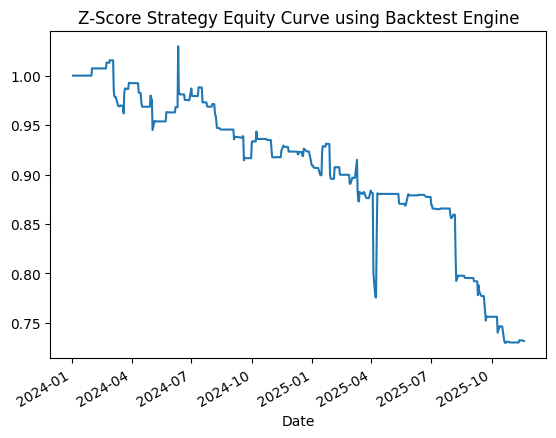

In [20]:
import sys
sys.path.append("../src/python")

from backtesting.single_asset_backtester import SingleAssetBacktester
from strategies.zscore_strategy import generate_zscore_signals

import pandas as pd

returns = pd.read_csv("../data/processed/market_returns.csv",
                      index_col=0, parse_dates=True)

rA = returns["AAPL"]
# signals = generate_zscore_signals(rA)
signals = generate_zscore_signals(rA, window=20, entry_z=1.0, max_size=1.5) # generate fractional signals (e.g. up to 1.5x exposure)

# bt = SingleAssetBacktester(rA)
bt = SingleAssetBacktester(rA, cost_per_turnover=0.0005)
equity, strat_ret, stats = bt.run_strategy(signals)

print(stats)
equity.plot(title="Z-Score Strategy Equity Curve using Backtest Engine")


### Compare Strategy #1 vs Strategy #2

In [21]:
from strategies.pairs_zscore_strategy import backtest_pairs_zscore
import pandas as pd

prices = pd.read_csv("../data/processed/adj_close_AAPL_MSFT.csv",
                     index_col=0, parse_dates=True)

equity2, ret2, stats2, _ = backtest_pairs_zscore(prices["AAPL"], prices["MSFT"])
print(stats2)


{'mean_return': np.float64(-0.0005097322672702022), 'volatility': 0.012225486848714225, 'sharpe': np.float64(-0.6618753908670235)}


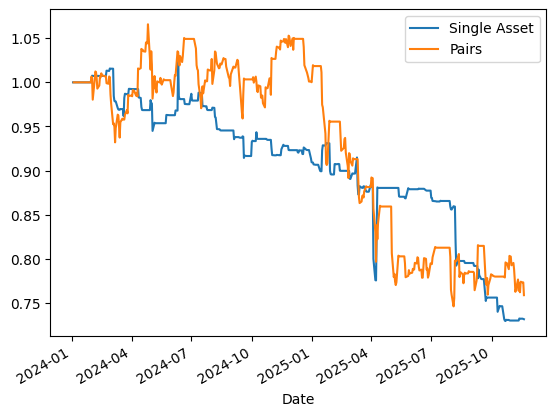

In [22]:
import matplotlib.pyplot as plt
equity.plot(label="Single Asset")
equity2.plot(label="Pairs")
plt.legend()


Interpretation:
- Both single-asset and pair mean-reversion strategies underperformed in late 2024–2025.
- This indicates a regime where the AAPL/MSFT spread became non-stationary and the historical relationship broke down.
- Mean reversion assumptions are valid only in certain regimes; when correlation deteriorates and spread drifts, the strategy loses edge.
- The pairs strategy showed more stability and less directional exposure, confirming its hedging benefits despite drawdown.

### Adding helper functions

In [37]:
import numpy as np

def compute_stats(strat_ret: pd.Series,
                  equity: pd.Series,
                  periods_per_year: int = 252):
    strat_ret = strat_ret.dropna()
    equity = equity.dropna()

    mean = strat_ret.mean()
    vol = strat_ret.std()
    sharpe = np.sqrt(periods_per_year) * mean / vol if vol != 0 else np.nan

    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    max_dd = drawdown.min()  # negative

    win_rate = (strat_ret > 0).mean()

    return {
        "mean": mean,
        "vol": vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "win_rate": win_rate,
    }


def apply_stoploss_to_returns(ret: pd.Series,
                              stop_drawdown: float = 0.15):
    """
    Given a series of strategy returns (after costs),
    apply a global stop-loss on max drawdown and return:
      - equity series with stop-loss
      - modified returns series (0 after stop).
    """
    eq_vals = []
    ret_sl_vals = []
    eq = 1.0
    peak = 1.0
    stopped = False

    for r in ret:
        if not stopped:
            eq *= (1.0 + r)
            peak = max(peak, eq)
            dd = 1.0 - eq / peak
            if dd > stop_drawdown:
                stopped = True
                r_effective = 0.0  # from now on, 0 return
            else:
                r_effective = r
        else:
            r_effective = 0.0  # flat after stop

        eq_vals.append(eq)
        ret_sl_vals.append(r_effective)

    equity_sl = pd.Series(eq_vals, index=ret.index, name="equity_sl")
    ret_sl = pd.Series(ret_sl_vals, index=ret.index, name="ret_sl")
    return equity_sl, ret_sl


### Backtesting using stoploss

Single Asset – no SL: {'mean': np.float64(-0.0006171942975426743), 'vol': 0.009288038123178726, 'sharpe': np.float64(-1.0548681649981837), 'max_drawdown': -0.29146133164823806, 'win_rate': np.float64(0.10570824524312897)}
Single Asset – 15% SL: {'mean': np.float64(-0.00027021688198131946), 'vol': 0.005815725594412329, 'sharpe': np.float64(-0.7375795073214119), 'max_drawdown': -0.1521481001645596, 'win_rate': np.float64(0.07399577167019028), 'stop_drawdown': 0.15}
Pairs – no SL: {'mean_return': np.float64(-0.0005097322672702022), 'volatility': 0.012225486848714225, 'sharpe': np.float64(-0.6618753908670235)}
Pairs – 15% SL: {'mean': np.float64(-0.0001411494669116447), 'vol': 0.008357026394758818, 'sharpe': np.float64(-0.2681190912871321), 'max_drawdown': -0.15086789753320262, 'win_rate': np.float64(0.15254237288135594)}


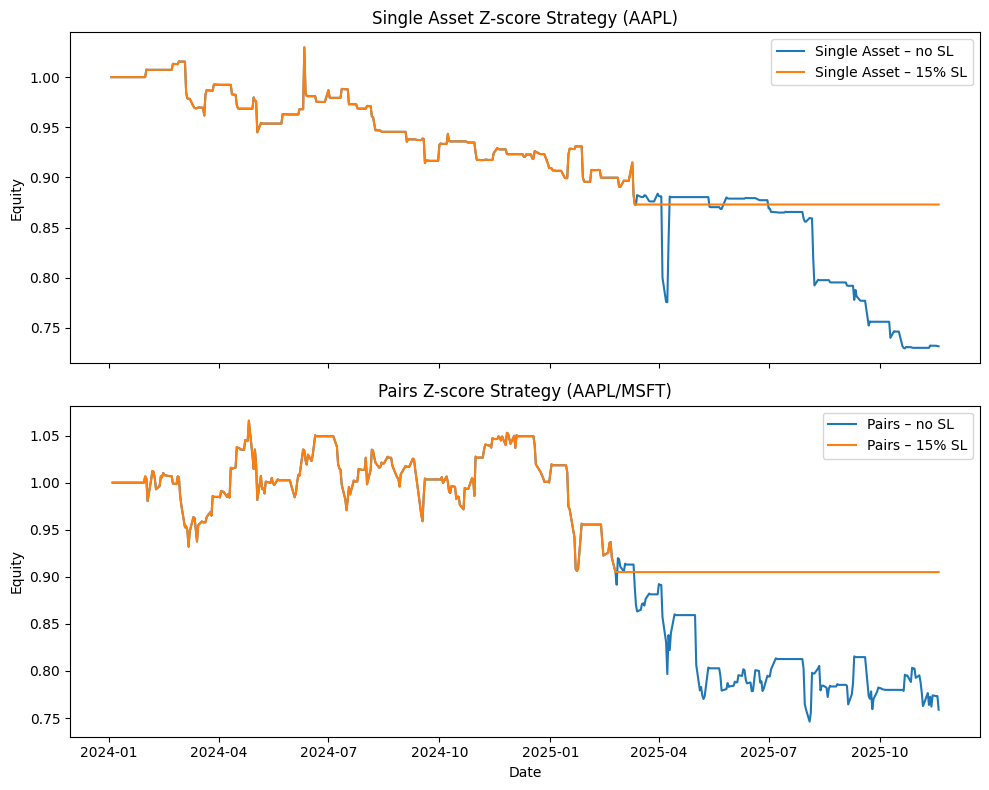

In [38]:
import sys
sys.path.append("../src/python")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from backtesting.single_asset_backtester import SingleAssetBacktester
from strategies.zscore_strategy import generate_zscore_signals
from strategies.pairs_zscore_strategy import backtest_pairs_zscore

# ---------- SINGLE-ASSET STRATEGY ----------
returns = pd.read_csv("../data/processed/market_returns.csv",
                      index_col=0, parse_dates=True)
rA = returns["AAPL"].dropna()

signals = generate_zscore_signals(rA, window=20, entry_z=1.0, max_size=1.5)

bt = SingleAssetBacktester(rA, cost_per_turnover=0.0005)

equity_sa, strat_ret_sa, stats_sa = bt.run_strategy(signals)
equity_sa_sl, strat_ret_sa_sl, stats_sa_sl = bt.run_strategy_with_stoploss(
    signals, stop_drawdown=0.15
)

print("Single Asset – no SL:", stats_sa)
print("Single Asset – 15% SL:", stats_sa_sl)

# ---------- PAIRS STRATEGY ----------
prices = pd.read_csv("../data/processed/adj_close_AAPL_MSFT.csv",
                     index_col=0, parse_dates=True)

equity_pair, ret_pair, stats_pair, z = backtest_pairs_zscore(
    prices["AAPL"], prices["MSFT"]
)

equity_pair_sl, ret_pair_sl = apply_stoploss_to_returns(ret_pair, stop_drawdown=0.15)

stats_pair_sl = compute_stats(ret_pair_sl, equity_pair_sl)

print("Pairs – no SL:", stats_pair)
print("Pairs – 15% SL:", stats_pair_sl)

# ---------- PLOTTING ----------
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# row 1: single asset
axes[0].plot(equity_sa.index, equity_sa, label="Single Asset – no SL")
axes[0].plot(equity_sa_sl.index, equity_sa_sl, label="Single Asset – 15% SL")
axes[0].set_title("Single Asset Z-score Strategy (AAPL)")
axes[0].set_ylabel("Equity")
axes[0].legend()

# row 2: pairs
axes[1].plot(equity_pair.index, equity_pair, label="Pairs – no SL")
axes[1].plot(equity_pair_sl.index, equity_pair_sl, label="Pairs – 15% SL")
axes[1].set_title("Pairs Z-score Strategy (AAPL/MSFT)")
axes[1].set_ylabel("Equity")
axes[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


Interpretation:

- max_drawdown: worst peak-to-trough fall

- win_rate: % of days with positive strategy return

- Sharpe Single Assest Trading :
    > - without stoploss ≈ -1.05
    > - with stoploss ≈ -0.74

- Sharpe Pair Trading :
  > - without stoploss ≈ -0.66
  > - with stoploss ≈ -0.27